In [1]:
# Import all the functions you need
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from pathlib import Path
import platform

# Comment here to add in for either mac or linux computer
if platform.system() == "Linux":   # for linux
    sys.path.extend(['/data/GitHub/NeuroPy']) 
    sys.path.extend(['/data/GitHub/TraceFC/'])
elif platform.system() == "Darwin":
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/TraceFC'])
elif platform.system() == "Windows":
    print('No windows repositories defined')

from neuropy import core
from neuropy.io import (optitrackio,
                        dlcio,
                        )
from neuropy.io.neuroscopeio import NeuroscopeIO
from neuropy.io.binarysignalio import BinarysignalIO 
from neuropy.io.miniscopeio import MiniscopeIO
from neuropy.core import Epoch
from neuropy.utils import plot_util
from neuropy.utils.signal_process import WaveletSg
from neuropy.plotting.spikes import plot_raster, plot_binned_raster
from neuropy.plotting.signals import plot_signal_w_epochs, plot_spectrogram
from neuropy.io.usvio import detect_tone

from tracefc.io.session_directory import get_session_dir

In [2]:
from neuropy.core.session import ProcessData

def sess_use(basepath=os.getcwd()):

    return ProcessData(basepath)

In [3]:
animal, sess_name = 'Jyn', 'recall7'
sess_dir = get_session_dir(animal, sess_name)
sess = sess_use(sess_dir)
print(sess.recinfo)

filename: /data2/Trace_FC/Recording_Rats/Jyn/2022_06_24_recall7/Jyn_recall7_denoised.xml 
# channels: 35
sampling rate: 30000
lfp Srate (downsampled): 1250



In [4]:
print(sess.eegfile)

duration: 3142.76 seconds 
duration: 0.87 hours 



### Read in DeepLabCut Data and sync with OpenEphys data

In [5]:
import neuropy.io.openephysio as oeio
sync_df = oeio.create_sync_df(sess.basepath)
sync_df["Time since rec start (sec)"] = (sync_df['Datetime'] - sync_df.loc[0, 'Datetime']).dt.total_seconds()
sync_df

start time = 2022-06-24 13:32:13.885532-04:00
start time = 2022-06-24 13:55:14.150541-04:00
start time = 2022-06-24 14:05:46.326088-04:00
start time = 2022-06-24 14:15:38.685070-04:00


,Recording,Datetime,Condition,nframe_dat,dat_time,nframe_eeg,eeg_time,Time since rec start (sec)
0,0,2022-06-24 13:32:13.885532-04:00,start,0,0.000000,0,0.0000,0.000000
1,0,2022-06-24 13:52:19.619898667-04:00,stop,36172031,1205.734367,1507167,1205.7336,1205.734367
2,1,2022-06-24 13:55:14.150541-04:00,start,36172032,1205.734400,1507168,1205.7344,1380.265009
3,1,2022-06-24 14:03:58.982241-04:00,stop,51916983,1730.566100,2163207,1730.5656,1905.096709
4,2,2022-06-24 14:05:46.326088-04:00,start,51916984,1730.566133,2163208,1730.5664,2012.440556
5,2,2022-06-24 14:14:59.874854667-04:00,stop,68523447,2284.114900,2855143,2284.1144,2565.989323
6,3,2022-06-24 14:15:38.685070-04:00,start,68523448,2284.114933,2855144,2284.1152,2604.799538
7,3,2022-06-24 14:29:57.326103333-04:00,stop,94282679,3142.755967,3928444,3142.7552,3463.440571


In [6]:
import neuropy.io.miniscopeio as miniio
mini = miniio.MiniscopeIO(sess.basepath)

In [7]:
mini.load_all_orientation()
mini.load_all_timestamps()

including folder /data2/Trace_FC/Recording_Rats/Jyn/2022_06_24_recall7/1_tone_recall/tone_recall/Jyn/gobears/2022_06_24/13_33_42
including folder /data2/Trace_FC/Recording_Rats/Jyn/2022_06_24_recall7/2_control_tone_recall/control_tone_recall/Jyn/gobears/2022_06_24/13_55_24
including folder /data2/Trace_FC/Recording_Rats/Jyn/2022_06_24_recall7/2_control_tone_recall/control_tone_recall/Jyn/gobears/2022_06_24/14_05_53
including folder /data2/Trace_FC/Recording_Rats/Jyn/2022_06_24_recall7/3_ctx_recall/ctx_recall/Jyn/gobears/2022_06_24/14_16_50


,Frame Number,Time Stamp (ms),Buffer Index,Timestamps
0,0,-20,0,2022-06-24 13:33:42.686
1,1,67,0,2022-06-24 13:33:42.773
2,2,112,0,2022-06-24 13:33:42.818
3,3,179,0,2022-06-24 13:33:42.885
4,4,247,0,2022-06-24 13:33:42.953
...,...,...,...,...
11578,11578,780045,0,2022-06-24 14:29:50.183
11579,11579,780112,0,2022-06-24 14:29:50.250
11580,11580,780180,0,2022-06-24 14:29:50.318
11581,11581,780248,0,2022-06-24 14:29:50.386


In [8]:
rough_headsensor_times = (mini.orient_all["Timestamps"].dt.tz_localize(tz="America/Detroit") - sync_df.loc[0, "Datetime"]).dt.total_seconds()
mini.orient_all["Rough eeg time (s)"] = rough_headsensor_times
mini.orient_all

,Time Stamp (ms),qw,qx,qy,qz,Timestamps,roll,pitch,yaw,Rough eeg time (s)
0,-20,-0.706299,-0.483154,0.210327,0.472717,2022-06-24 13:33:42.686,1.103549,0.160370,-1.080780,88.800468
1,67,-0.710388,-0.477722,0.208496,0.472961,2022-06-24 13:33:42.773,1.090267,0.156295,-1.079884,88.887468
2,112,-0.711060,-0.471741,0.210693,0.476868,2022-06-24 13:33:42.818,1.079796,0.150862,-1.090957,88.932468
3,179,-0.713074,-0.470947,0.211304,0.474426,2022-06-24 13:33:42.885,1.079073,0.146027,-1.086604,88.999468
4,247,-0.716614,-0.472839,0.207886,0.468628,2022-06-24 13:33:42.953,1.079889,0.145743,-1.070815,89.067468
...,...,...,...,...,...,...,...,...,...,...
11578,780045,0.794922,0.069092,0.147461,0.584412,2022-06-24 14:29:50.183,0.289627,0.154300,1.290405,3456.297468
11579,780112,0.774353,0.054565,0.142761,0.613953,2022-06-24 14:29:50.250,0.266073,0.154720,1.361412,3456.364468
11580,780180,0.759888,0.037842,0.137573,0.634155,2022-06-24 14:29:50.318,0.237287,0.161798,1.410168,3456.432468
11581,780248,0.739624,0.014404,0.135254,0.659180,2022-06-24 14:29:50.386,0.204396,0.182078,1.474691,3456.500468


In [9]:
rough_headsensor_times = (mini.orient_all["Timestamps"].dt.tz_localize(tz="America/Detroit") - sync_df.loc[0, "Datetime"]).dt.total_seconds()
mini.orient_all["Time from OE start"] = rough_headsensor_times
mini.orient_all

# Key line of code - converts miniscope time (which doesn't account for disconnects) to eeg time (which cuts out disconnect times)
mini.orient_all["Rough eeg time (s)"] = np.interp(mini.orient_all["Time from OE start"], sync_df["Time since rec start (sec)"], 
                                            sync_df["eeg_time"])
mini.orient_all

,Time Stamp (ms),qw,qx,qy,qz,Timestamps,roll,pitch,yaw,Rough eeg time (s),Time from OE start
0,-20,-0.706299,-0.483154,0.210327,0.472717,2022-06-24 13:33:42.686,1.103549,0.160370,-1.080780,88.800412,88.800468
1,67,-0.710388,-0.477722,0.208496,0.472961,2022-06-24 13:33:42.773,1.090267,0.156295,-1.079884,88.887411,88.887468
2,112,-0.711060,-0.471741,0.210693,0.476868,2022-06-24 13:33:42.818,1.079796,0.150862,-1.090957,88.932411,88.932468
3,179,-0.713074,-0.470947,0.211304,0.474426,2022-06-24 13:33:42.885,1.079073,0.146027,-1.086604,88.999411,88.999468
4,247,-0.716614,-0.472839,0.207886,0.468628,2022-06-24 13:33:42.953,1.079889,0.145743,-1.070815,89.067411,89.067468
...,...,...,...,...,...,...,...,...,...,...,...
11578,780045,0.794922,0.069092,0.147461,0.584412,2022-06-24 14:29:50.183,0.289627,0.154300,1.290405,3135.612105,3456.297468
11579,780112,0.774353,0.054565,0.142761,0.613953,2022-06-24 14:29:50.250,0.266073,0.154720,1.361412,3135.679105,3456.364468
11580,780180,0.759888,0.037842,0.137573,0.634155,2022-06-24 14:29:50.318,0.237287,0.161798,1.410168,3135.747105,3456.432468
11581,780248,0.739624,0.014404,0.135254,0.659180,2022-06-24 14:29:50.386,0.204396,0.182078,1.474691,3135.815105,3456.500468


In [10]:
sess.filePrefix

PosixPath('/data2/Trace_FC/Recording_Rats/Jyn/2022_06_24_recall7/Jyn_recall7_denoised')

In [65]:
cs_epochs_file = sess.filePrefix.with_suffix(".cs_epochs.npy")
sess.cs_epochs = Epoch(epochs=None, file=cs_epochs_file)
sess.cs_epochs.starts

array([], dtype=float64)

In [66]:
# sess.cs_epochs = Epoch(epochs=cs_wav_epochs_aligned.to_dataframe())

In [67]:
# sess.csn_epochs = Epoch(epochs=csn_wav_epochs_aligned.to_dataframe())

In [68]:
csn_epochs_file = sess.filePrefix.with_suffix(".csn_epochs.npy")
sess.csn_epochs = Epoch(epochs=None, file=csn_epochs_file)
sess.csn_epochs.starts

array([1277.794792, 1358.748792, 1427.540525, 1496.331325, 1562.062359,
       1634.912459, 1709.792125, 1750.698678, 1818.473712, 1879.131212,
       1958.070545])

In [69]:
cs2_epochs_file = sess.filePrefix.with_suffix(".cs2_epochs.npy")
sess.cs2_epochs = Epoch(epochs=None, file=cs2_epochs_file)
sess.cs2_epochs.starts

array([2018.743012, 2080.415245, 2159.354112])

In [70]:
sync_df

,Recording,Datetime,Condition,nframe_dat,dat_time,nframe_eeg,eeg_time
0,0,2022-06-24 13:32:13.885532-04:00,start,0,0.000000,0,0.0000
1,0,2022-06-24 13:52:19.619898667-04:00,stop,36172031,1205.734367,1507167,1205.7336
2,1,2022-06-24 13:55:14.150541-04:00,start,36172032,1205.734400,1507168,1205.7344
3,1,2022-06-24 14:03:58.982241-04:00,stop,51916983,1730.566100,2163207,1730.5656
4,2,2022-06-24 14:05:46.326088-04:00,start,51916984,1730.566133,2163208,1730.5664
5,2,2022-06-24 14:14:59.874854667-04:00,stop,68523447,2284.114900,2855143,2284.1144
6,3,2022-06-24 14:15:38.685070-04:00,start,68523448,2284.114933,2855144,2284.1152
7,3,2022-06-24 14:29:57.326103333-04:00,stop,94282679,3142.755967,3928444,3142.7552


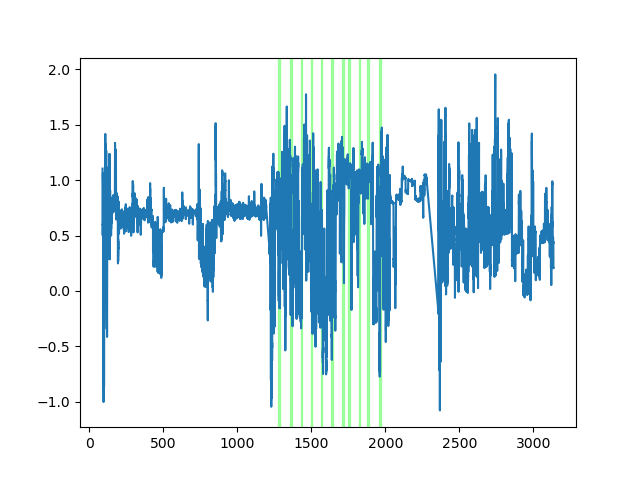

In [71]:
%matplotlib widget
_, ax = plt.subplots()
ax.plot(mini.orient_all["Rough eeg time (s)"], mini.orient_all.roll)
for start, stop in zip(cs_epochs.starts, cs_epochs.stops):
    ax.axvspan(start, stop, color=[1, 0, 0, 0.3])

for start, stop in zip(csn_epochs.starts, csn_epochs.stops):
    ax.axvspan(start, stop, color=[0, 1 , 0, 0.3])

# for start, stop in zip(sess.cs2_epochs.starts, sess.cs2_epochs.stops):
#     ax.axvspan(start, stop, color=[1, 0, 0, 0.3])

In [17]:
def calc_head_speed(df):

    angle_diffs = []
    for ang_axis in ["roll", "pitch", "yaw"]:
        axis_diff = df[ang_axis].diff()

        # Correct any swings of > 2*pi
        axis_diff[axis_diff > 1.8 * np.pi] = axis_diff[axis_diff > 1.8 * np.pi] - 2 * np.pi
        axis_diff[axis_diff < -1.8 * np.pi] = axis_diff[axis_diff < -1.8 * np.pi] + 2 * np.pi
        angle_diffs.append(axis_diff.values)
    # head_speed = np.sqrt(np.square(df.roll.diff()) + np.square(df.pitch.diff()) + np.square(df.yaw.diff())) / df["Rough eeg time (s)"].diff()
    head_speed = np.sqrt(np.square(angle_diffs[0]) + np.square(angle_diffs[1]) + np.square(angle_diffs[2]))
    return head_speed
calc_head_speed(mini.orient_all)

array([       nan, 0.01392181, 0.01617859, ..., 0.05705977, 0.07520914,
       0.0256886 ])

AttributeError: 'ProcessData' object has no attribute 'cs_epochs'

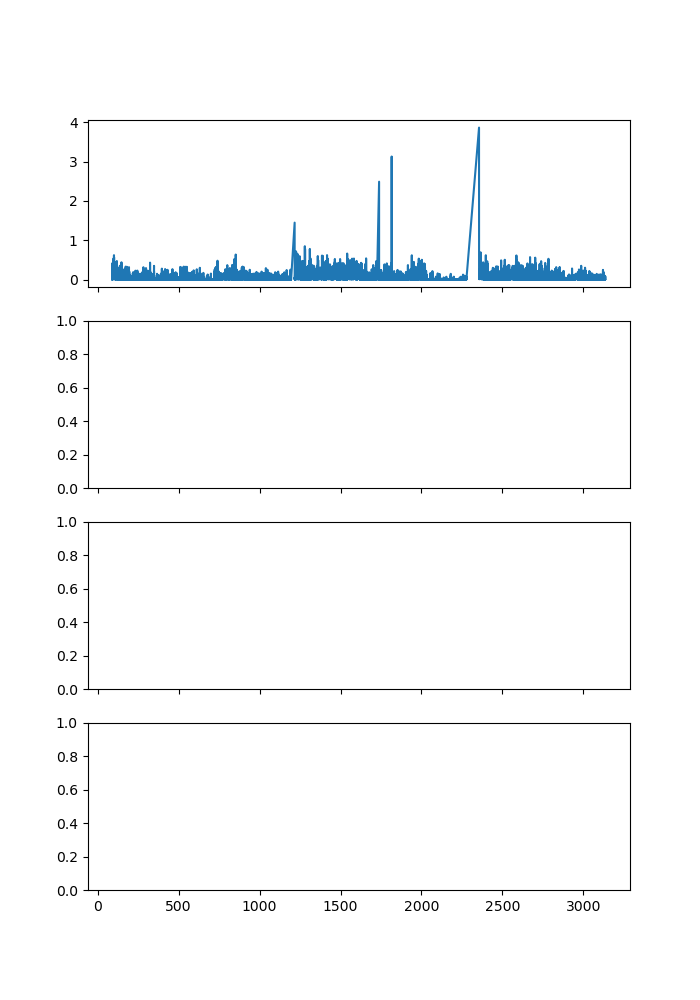

In [18]:
%matplotlib widget
_, axs = plt.subplots(4, 1, figsize=(7, 10), sharex=True)
ax = axs[0]
mini.orient_all["Head speed"] = calc_head_speed(mini.orient_all)
ax.plot(mini.orient_all["Rough eeg time (s)"], mini.orient_all["Head speed"])
for start, stop in zip(sess.cs_epochs.starts, sess.cs_epochs.stops):
    ax.axvspan(start, stop, color=[1, 0, 0, 0.3])

for start, stop in zip(sess.csn_epochs.starts, sess.csn_epochs.stops):
    ax.axvspan(start, stop, color=[0, 1, 0, 0.3])

for start, stop in zip(sess.cs2_epochs.starts, sess.cs2_epochs.stops):
    ax.axvspan(start, stop, color=[1, 0, 0, 0.3])

ax = axs[1]
ax.plot(mini.orient_all["Rough eeg time (s)"], mini.orient_all.pitch)
for start, stop in zip(sess.cs_epochs.starts, sess.cs_epochs.stops):
    ax.axvspan(start, stop, color=[1, 0, 0, 0.3])

for start, stop in zip(sess.csn_epochs.starts, sess.csn_epochs.stops):
    ax.axvspan(start, stop, color=[0, 1, 0, 0.3])

for start, stop in zip(sess.cs2_epochs.starts, sess.cs2_epochs.stops):
    ax.axvspan(start, stop, color=[1, 0, 0, 0.3])

ax = axs[2]
ax.plot(mini.orient_all["Rough eeg time (s)"], mini.orient_all.yaw)
for start, stop in zip(sess.cs_epochs.starts, sess.cs_epochs.stops):
    ax.axvspan(start, stop, color=[1, 0, 0, 0.3])

for start, stop in zip(sess.csn_epochs.starts, sess.csn_epochs.stops):
    ax.axvspan(start, stop, color=[0, 1, 0, 0.3])

for start, stop in zip(sess.cs2_epochs.starts, sess.cs2_epochs.stops):
    ax.axvspan(start, stop, color=[1, 0, 0, 0.3])

ax = axs[3]
ax.plot(mini.orient_all["Rough eeg time (s)"], mini.orient_all.roll)
for start, stop in zip(sess.cs_epochs.starts, sess.cs_epochs.stops):
    ax.axvspan(start, stop, color=[1, 0, 0, 0.3])

for start, stop in zip(sess.csn_epochs.starts, sess.csn_epochs.stops):
    ax.axvspan(start, stop, color=[0, 1, 0, 0.3])

for start, stop in zip(sess.cs2_epochs.starts, sess.cs2_epochs.stops):
    ax.axvspan(start, stop, color=[1, 0, 0, 0.3])

In [ ]:
import neuropy.io.dlcio as dlcio
dlc_path = '/data3/Trace_FC/Recording_Rats/Finn2/2023_05_09_recall1'
arena_side_pix = 60  # Keep this
arena_side_cm = 25.4  # Update this after measuring!!!
pix2cm = arena_side_cm / arena_side_pix

# Read in DLC data
sess.dlc = dlcio.DLC(dlc_path, pix2cm=pix2cm)

# Smooth position, get timestamps, and get speed
sess.dlc.get_timestamps('ms_webcam', include_str="1_tone_recall")
sess.dlc.smooth_pos(bodyparts=["crown_middle", "back_middle"])
sess.dlc.timestamps["Timestamps"] = sess.dlc.timestamps["Timestamps"].dt.tz_localize("America/Detroit")
sess.dlc.get_all_speed()

In [ ]:
# Load in openephys times to sync
import neuropy.io.openephysio as oeio
sync_df = oeio.create_sync_df(sess.basepath)
sync_df["Total seconds from start"] = (sync_df["Datetime"] - sync_df["Datetime"][0]).dt.total_seconds()

# sync DLC times to your eeg file
sess.dlc.timestamps["Total seconds from OE start"] = (sess.dlc.timestamps["Timestamps"] - sync_df["Datetime"][0]).dt.total_seconds()
sess.dlc.timestamps["eeg_time"] = np.interp(sess.dlc.timestamps["Total seconds from OE start"], sync_df["Total seconds from start"], 
                                            sync_df["eeg_time"])
sess.dlc.timestamps

In [ ]:
# Last calculate freezing times and plot again to check
frz_thresh = 0.25 # cm/sec  Adjust this to something that looks reasonable!
duration_thresh = 1 # sec, must be below the threshold above for at least that long to be considered freezing
bodypart_use = "crown_middle"
frz_bool = sess.dlc.speed[bodypart_use] < frz_thresh
frz_epochs = Epoch.from_boolean_array(frz_bool, t=sess.dlc.timestamps["eeg_time"])
frz_df = frz_epochs.to_dataframe()
frz_df = frz_df[frz_epochs.durations > duration_thresh]
frz_epochs = Epoch(frz_df)
frz_epochs

In [ ]:
%matplotlib widget
# Plot to check! Looks ok, though there might be some mismatches between theta and movement.

_, ax = plt.subplots(figsize=(12, 4))
hc, = ax.plot(sess.dlc.timestamps["eeg_time"], sess.dlc.speed["crown_middle"])
hb, = ax.plot(sess.dlc.timestamps["eeg_time"], sess.dlc.speed["back_middle"])
hthresh = ax.axhline(frz_thresh, color='r', linestyle='--')

for start, stop in zip(frz_epochs.starts, frz_epochs.stops):
    hf = ax.axvspan(start, stop, color=[0.3, 0, 0, 0.5])

# Now plot theta epochs over it to triple check!
theta_epochs_file = sess.filePrefix.with_suffix(".theta_epochs.npy")
theta_epochs = Epoch(epochs=None, file=theta_epochs_file)
theta_epochs = theta_epochs.time_slice(t_start = sess.dlc.timestamps["eeg_time"].min(), t_stop=sess.dlc.timestamps["eeg_time"].max())

for start, stop in zip(theta_epochs.starts, theta_epochs.stops):
    htheta = ax.axvspan(start, stop, color=[0, 0.3, 0, 0.5])

ax.legend((hc, hb, hthresh, htheta, hf), ("crown_middle", "back_middle", "freeze threshold", "theta", "frz"))

#### Double check start time

In [ ]:
import neuropy.io.openephysio as oeio

# Import TTLs for CS from OpenEphys
ttl_df = oeio.load_all_ttl_events(sess.basepath, sanity_check_channel=1, zero_timestamps=True)
ttl_df[ttl_df['channel_states'].abs() == 2].head(5)

In [ ]:
accurate_start_time = ttl_df[ttl_df['channel_states'].abs() == 1].iloc[6355]['datetimes']
accurate_start_time = accurate_start_time.tz_localize('America/Detroit')

In [ ]:
approx_start_time = sess.dlc.timestamps.loc[0, 'Timestamps']
approx_start_time

In [ ]:
adj_time_delta = (accurate_start_time - approx_start_time).total_seconds()
adj_time_delta

In [ ]:
sess.dlc.timestamps.head(1)

In [ ]:
# Try manually adjusting times in DLC data and see if it matches better!
from copy import deepcopy
dlcadj = deepcopy(sess.dlc)

dlcadj.timestamps["eeg_time"] = dlcadj.timestamps["eeg_time"] + adj_time_delta

_, axcomb = plt.subplots(2, 1, sharex=True, figsize=(12, 5))
ax = axcomb[0]
hc, = ax.plot(dlcadj.timestamps["eeg_time"], dlcadj.speed["crown_middle"])
hb, = ax.plot(dlcadj.timestamps["eeg_time"], dlcadj.speed["back_middle"])
hthresh = ax.axhline(frz_thresh, color='r', linestyle='--')

for start, stop in zip(frz_epochs.starts, frz_epochs.stops):
    hf = ax.axvspan(start, stop, color=[0.3, 0, 0, 0.5])

# Now plot theta epochs over it to triple check!
theta_epochs_file = sess.filePrefix.with_suffix(".theta_epochs.npy")
theta_epochs = Epoch(epochs=None, file=theta_epochs_file)
theta_epochs = theta_epochs.time_slice(t_start = dlcadj.timestamps["eeg_time"].min(), t_stop=dlcadj.timestamps["eeg_time"].max())

for start, stop in zip(theta_epochs.starts, theta_epochs.stops):
    htheta = ax.axvspan(start, stop, color=[0, 0.3, 0, 0.5])

ax.legend((hc, hb, hthresh, htheta, hf), ("crown_middle", "back_middle", "freeze threshold", "theta", "frz"))
# ax.set_xlim((2535, 2565))

plot_signal_w_epochs(signal, 28, art_epochs, ax=axcomb[1])

In [19]:
# Try manually adjusting times in DLC data and see if it matches better!
from copy import deepcopy
manually_adjust_dlc_times = -0.528  # seconds
dlcadj = deepcopy(sess.dlc)

dlcadj.timestamps["eeg_time"] = dlcadj.timestamps["eeg_time"] + manually_adjust_dlc_times

_, ax = plt.subplots(figsize=(12, 4))

hthresh = ax.axhline(frz_thresh, color='r', linestyle='--')

for start, stop in zip(frz_epochs.starts, frz_epochs.stops):

    hf = ax.axvspan(start, stop, color=[0.3, 0, 0, 0.5])

# Now plot theta epochs over it to triple check!
theta_epochs_file = sess.filePrefix.with_suffix(".theta_epochs.npy")
theta_epochs = Epoch(epochs=None, file=theta_epochs_file)
theta_epochs = theta_epochs.time_slice(t_start = dlcadj.timestamps["eeg_time"].min(), t_stop=dlcadj.timestamps["eeg_time"].max())

for start, stop in zip(theta_epochs.starts, theta_epochs.stops):
    htheta = ax.axvspan(start, stop, color=[0, 0.3, 0, 0.5])

ax.legend((hc, hb, hthresh, htheta, hf), ("crown_middle", "back_middle", "freeze threshold", "theta", "frz"))
# ax.set_xlim((2535, 2565))

AttributeError: 'ProcessData' object has no attribute 'dlc'

In [ ]:
#Freezing and theta
from copy import deepcopy

manually_adjust_dlc_times = -0.528  
dlcadj = deepcopy(sess.dlc)
dlcadj.timestamps["eeg_time"] = dlcadj.timestamps["eeg_time"] + manually_adjust_dlc_times

_, ax = plt.subplots(figsize=(12, 4))
hthresh = ax.axhline(frz_thresh, color='r', linestyle='--')

for start, stop in zip(frz_epochs.starts, frz_epochs.stops):
    duration = stop - start
    if duration > 4:  # Check if the frz epoch duration is greater than 5 seconds
        hf = ax.axvspan(start, stop, color=[0.3, 0, 0, 0.5], label='frz')

theta_epochs_file = sess.filePrefix.with_suffix(".theta_epochs.npy")
theta_epochs = Epoch(epochs=None, file=theta_epochs_file)
theta_epochs = theta_epochs.time_slice(t_start=dlcadj.timestamps["eeg_time"].min(), t_stop=dlcadj.timestamps["eeg_time"].max())

beta_epochs_file = sess.filePrefix.with_suffix(".beta_epochs.npy")
beta_epochs = Epoch(epochs=None, file=beta_epochs_file)
beta_epochs = beta_epochs.time_slice(t_start=dlcadj.timestamps["eeg_time"].min(), t_stop=dlcadj.timestamps["eeg_time"].max())

for start, stop in zip(theta_epochs.starts, theta_epochs.stops):
    htheta = ax.axvspan(start, stop, color=[0, 0.3, 0, 0.5], label='theta')
    
    
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  
ax.legend(by_label.values(), by_label.keys())


In [20]:
#Freezing and ripple
from copy import deepcopy

manually_adjust_dlc_times = -0.528  
dlcadj = deepcopy(sess.dlc)
dlcadj.timestamps["eeg_time"] = dlcadj.timestamps["eeg_time"] + manually_adjust_dlc_times

_, ax = plt.subplots(figsize=(12, 4))
hthresh = ax.axhline(frz_thresh, color='r', linestyle='--')

for start, stop in zip(frz_epochs.starts, frz_epochs.stops):
    duration = stop - start
    if duration > 4:  # Check if the frz epoch duration is greater than 5 seconds
        hf = ax.axvspan(start, stop, color=[0.3, 0, 0, 0.5], label='frz')

ripple_epochs_file = sess.filePrefix.with_suffix(".ripple_epochs.npy")
ripple_epochs = Epoch(epochs=None, file=ripple_epochs_file)
ripple_epochs = ripple_epochs.time_slice(t_start=dlcadj.timestamps["eeg_time"].min(), t_stop=dlcadj.timestamps["eeg_time"].max())

beta_epochs_file = sess.filePrefix.with_suffix(".beta_epochs.npy")
beta_epochs = Epoch(epochs=None, file=beta_epochs_file)
beta_epochs = beta_epochs.time_slice(t_start=dlcadj.timestamps["eeg_time"].min(), t_stop=dlcadj.timestamps["eeg_time"].max())

for start, stop in zip(ripple_epochs.starts, ripple_epochs.stops):
    hripple = ax.axvspan(start, stop, color=[0, 0.3, 0, 0.5], label='ripple')
    
    
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  
ax.legend(by_label.values(), by_label.keys())


AttributeError: 'ProcessData' object has no attribute 'dlc'

In [25]:
#Freezing and ripple
from copy import deepcopy
import matplotlib.pyplot as plt

# Assuming sess, frz_thresh, frz_epochs, and other necessary variables are defined elsewhere

manually_adjust_dlc_times = -0.528  
dlcadj = deepcopy(sess.dlc)
dlcadj.timestamps["eeg_time"] = dlcadj.timestamps["eeg_time"] + manually_adjust_dlc_times

_, ax = plt.subplots(figsize=(12, 4))

# Use axhline to draw lines for visual separation (optional)
ax.axhline(0.5, color='k', linestyle='-', alpha=0.5)  # Mid-line for visual separation

# Plot freezing events below the line
for start, stop in zip(frz_epochs.starts, frz_epochs.stops):
    duration = stop - start
    ax.axvspan(start, stop, ymin=0, ymax=0.5, color=[0.3, 0, 0, 0.5], label='frz')

# Plot ripple events above the line
for start, stop in zip(ripple_epochs.starts, ripple_epochs.stops):
    ax.axvspan(start, stop, ymin=0.5, ymax=1, color=[0, 0.3, 0, 0.5], label='ripple')

# Adjust the y-axis to hide the y-ticks and labels as they don't represent meaningful values in this context
ax.set_yticks([])
ax.set_ylabel("Events")

# Handle legend to avoid duplicate labels
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

plt.tight_layout()
plt.show()

AttributeError: 'ProcessData' object has no attribute 'dlc'

In [26]:
#Freezing and beta
from copy import deepcopy

manually_adjust_dlc_times = -0.528
dlcadj = deepcopy(sess.dlc)
dlcadj.timestamps["eeg_time"] = dlcadj.timestamps["eeg_time"] + manually_adjust_dlc_times

_, ax = plt.subplots(figsize=(12, 4))
hthresh = ax.axhline(frz_thresh, color='r', linestyle='--')

for start, stop in zip(frz_epochs.starts, frz_epochs.stops):
    duration = stop - start
    if duration > 4:  # Check if the frz epoch duration is greater than 5 seconds
        hf = ax.axvspan(start, stop, color=[0.3, 0, 0, 0.5], label='frz')

theta_epochs_file = sess.filePrefix.with_suffix(".theta_epochs.npy")
theta_epochs = Epoch(epochs=None, file=theta_epochs_file)
theta_epochs = theta_epochs.time_slice(t_start=dlcadj.timestamps["eeg_time"].min(), t_stop=dlcadj.timestamps["eeg_time"].max())

beta_epochs_file = sess.filePrefix.with_suffix(".beta_epochs.npy")
beta_epochs = Epoch(epochs=None, file=beta_epochs_file)
beta_epochs = beta_epochs.time_slice(t_start=dlcadj.timestamps["eeg_time"].min(), t_stop=dlcadj.timestamps["eeg_time"].max())


    
for start, stop in zip(beta_epochs.starts, beta_epochs.stops):
    hbeta = ax.axvspan(start, stop, color=[0, 0, 0.3, 0.5], label='beta')
    
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  
ax.legend(by_label.values(), by_label.keys())

AttributeError: 'ProcessData' object has no attribute 'dlc'

In [27]:
#Freezing and gamma  Gamma detection is wrong?
from copy import deepcopy

manually_adjust_dlc_times = -0.528 
dlcadj = deepcopy(sess.dlc)
dlcadj.timestamps["eeg_time"] = dlcadj.timestamps["eeg_time"] + manually_adjust_dlc_times

_, ax = plt.subplots(figsize=(12, 4))
hthresh = ax.axhline(frz_thresh, color='r', linestyle='--')

for start, stop in zip(frz_epochs.starts, frz_epochs.stops):
    duration = stop - start
    if duration > 4:  # Check if the frz epoch duration is greater than 5 seconds
        hf = ax.axvspan(start, stop, color=[0.3, 0, 0, 0.5], label='frz')

theta_epochs_file = sess.filePrefix.with_suffix(".theta_epochs.npy")
theta_epochs = Epoch(epochs=None, file=theta_epochs_file)
theta_epochs = theta_epochs.time_slice(t_start=dlcadj.timestamps["eeg_time"].min(), t_stop=dlcadj.timestamps["eeg_time"].max())

gamma_epochs_file = sess.filePrefix.with_suffix(".gamma_epochs.npy")
gamma_epochs = Epoch(epochs=None, file=gamma_epochs_file)
gamma_epochs = gamma_epochs.time_slice(t_start=dlcadj.timestamps["eeg_time"].min(), t_stop=dlcadj.timestamps["eeg_time"].max())


    
for start, stop in zip(gamma_epochs.starts, gamma_epochs.stops):
    hgamma = ax.axvspan(start, stop, color=[0, 0, 0.3, 0.5], label='gamma')
    
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  
ax.legend(by_label.values(), by_label.keys())

AttributeError: 'ProcessData' object has no attribute 'dlc'

In [28]:
#Freezing and delta
from copy import deepcopy

manually_adjust_dlc_times = -0.528 
dlcadj = deepcopy(sess.dlc)
dlcadj.timestamps["eeg_time"] = dlcadj.timestamps["eeg_time"] + manually_adjust_dlc_times

_, ax = plt.subplots(figsize=(12, 4))
hthresh = ax.axhline(frz_thresh, color='r', linestyle='--')

for start, stop in zip(frz_epochs.starts, frz_epochs.stops):
    duration = stop - start
    if duration > 4:  # Check if the frz epoch duration is greater than 5 seconds
        hf = ax.axvspan(start, stop, color=[0.3, 0, 0, 0.5], label='frz')

# theta_epochs_file = sess.filePrefix.with_suffix(".theta_epochs.npy")
# theta_epochs = Epoch(epochs=None, file=theta_epochs_file)
# theta_epochs = theta_epochs.time_slice(t_start=dlcadj.timestamps["eeg_time"].min(), t_stop=dlcadj.timestamps["eeg_time"].max())

delta_epochs_file = sess.filePrefix.with_suffix(".delta_epochs.npy")
delta_epochs = Epoch(epochs=None, file=delta_epochs_file)
delta_epochs = delta_epochs.time_slice(t_start=dlcadj.timestamps["eeg_time"].min(), t_stop=dlcadj.timestamps["eeg_time"].max())


    
for start, stop in zip(delta_epochs.starts, delta_epochs.stops):
    duration = stop-start
    if duration>0.2:
        hdelta = ax.axvspan(start, stop, color=[0, 0, 0.3, 0.5], label='delta')
    
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  
ax.legend(by_label.values(), by_label.keys())

AttributeError: 'ProcessData' object has no attribute 'dlc'

In [29]:
#Freezing and USV
from copy import deepcopy

manually_adjust_dlc_times = -0.528 
dlcadj = deepcopy(sess.dlc)
dlcadj.timestamps["eeg_time"] = dlcadj.timestamps["eeg_time"] + manually_adjust_dlc_times

_, ax = plt.subplots(figsize=(12, 4))
hthresh = ax.axhline(frz_thresh, color='r', linestyle='--')

for start, stop in zip(frz_epochs.starts, frz_epochs.stops):
    duration = stop - start
    hf = ax.axvspan(start, stop, color=[0.3, 0, 0, 0.5], label='frz')

# theta_epochs_file = sess.filePrefix.with_suffix(".theta_epochs.npy")
# theta_epochs = Epoch(epochs=None, file=theta_epochs_file)
# theta_epochs = theta_epochs.time_slice(t_start=dlcadj.timestamps["eeg_time"].min(), t_stop=dlcadj.timestamps["eeg_time"].max())

usv_epochs_file = sess.filePrefix.with_suffix(".usv_epochs.npy")
usv_epochs = Epoch(epochs=None, file=usv_epochs_file)
usv_epochs


# delta_epochs_file = sess.filePrefix.with_suffix(".delta_epochs.npy")
# delta_epochs = Epoch(epochs=None, file=delta_epochs_file)
# delta_epochs = delta_epochs.time_slice(t_start=dlcadj.timestamps["eeg_time"].min(), t_stop=dlcadj.timestamps["eeg_time"].max())


    
for start, stop in zip(usv_epochs.starts, usv_epochs.stops):
    duration = stop-start

    husv = ax.axvspan(start, stop, color=[0, 0, 0.3, 0.5], label='usv')
    
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  
ax.legend(by_label.values(), by_label.keys())

AttributeError: 'ProcessData' object has no attribute 'dlc'

## Save notebook to animal working directory

In [56]:
from neuropy.utils.manipulate_files import save_notebook
try:
    save_notebook(sess.basepath, save_prepend=f"{animal}_{sess_name}_")
except PermissionError:
    print('Got a weird PermissionError. Check to make sure file saved successfully')

/data/GitHub/TraceFC/Notebooks/Animal_files/Recall2 Notebooks/Rec1-Sync_USV_and_Ephys(Jyn).ipynb saved to /data2/Trace_FC/Recording_Rats/Jyn/2022_06_19_recall2/Jyn_recall2_Rec1-Sync_USV_and_Ephys(Jyn).ipynb


### Load in disconnect and motion artifacts

In [21]:
from neuropy.analyses.artifact import detect_artifact_epochs
signal = sess.eegfile.get_signal()
buffer_add = 0.25  # seconds, None = don't add

art_epochs_file = sess.filePrefix.with_suffix(".art_epochs.npy")
if art_epochs_file.exists():
    art_epochs = Epoch(epochs=None, file=art_epochs_file)
    print('Existing artifact epochs file loaded')
else:
    # art_epochs = detect_artifact_epochs(signal, thresh=8, 
    #                                 edge_cutoff=3, merge=6)

    # Pick a particular channel with the code below
    art_epochs = detect_artifact_epochs(signal.time_slice(channel_id=31), thresh=11, 
                                    edge_cutoff=3, merge=6)

    if buffer_add is not None:  # Add in buffer to prevent erroneous detection of start/stop of artifact as SWRs
        art_epochs.add_epoch_buffer(buffer_add)
    sess.recinfo.write_epochs(epochs=art_epochs, ext='art')
    art_epochs.save(art_epochs_file)

print(f'Total artifact time = {art_epochs.durations.sum():0.1F} seconds')
art_epochs.to_dataframe()

/home/bowenw/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


Buffer of 0.25 added before/after each epoch
/data2/Trace_FC/Recording_Rats/Jyn/2022_06_24_recall7/Jyn_recall7_denoised.art_epochs.npy saved
Total artifact time = 4.5 seconds


,start,stop,label,duration
0,1205.4844,1207.2516,,1.7672
1,1223.6140,1224.1708,,0.5568
2,1390.0884,1390.5956,,0.5072
3,1730.3164,1732.0316,,1.7152


<Axes: >

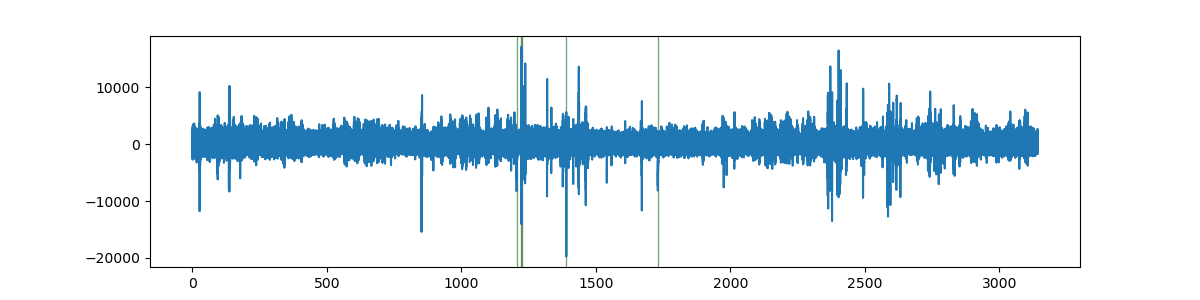

In [22]:
%matplotlib widget

chan_plot = 28
plot_signal_w_epochs(signal, 28, art_epochs)

## Define probe group

/data2/Trace_FC/Recording_Rats/Jyn/2022_06_19_recall2/Jyn_recall2_denoised.probegroup.npy saved


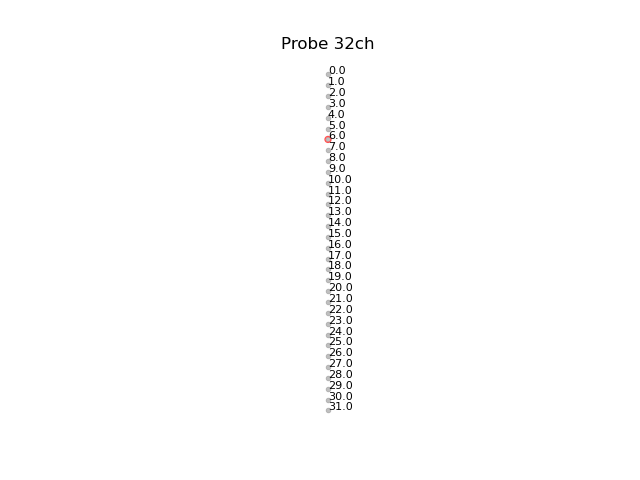

In [59]:
from neuropy.core import Shank, Probe, ProbeGroup
from neuropy.plotting import plot_probe
shank = Shank()
shank = shank.auto_generate(columns=1, contacts_per_column=32, xpitch=0,
                   ypitch=20, channel_id=np.arange(31, -1, -1))
shank.set_disconnected_channels(sess.recinfo.skipped_channels)
probe = Probe(shank)
prbgrp = ProbeGroup()
prbgrp.add_probe(probe)
plot_probe(prbgrp)
prbgrp.filename = sess.filePrefix.with_suffix(".probegroup.npy")
prbgrp.save(prbgrp.filename)
sess.prbgrp = prbgrp

## Detect delta epochs

In [60]:
#Detect Delta
from neuropy.analyses.oscillations import detect_hpc_delta_wave_epochs
freq_band = (0.5, 4)
min_dur = 0.15  
max_dur = 0.5   
ignore_epochs = None  
delta_channel = 59  

if delta_channel is not None:
    signal_use = signal.time_slice(channel_id=delta_channel)
else:
    signal_use = signal
delta_epochs = detect_hpc_delta_wave_epochs(
    signal_use, freq_band=freq_band, min_dur=min_dur, max_dur=max_dur, ignore_epochs=ignore_epochs
)

ValueError: 59 is not in list

## Detect Beta epochs

In [ ]:
#Detect Beta
from neuropy.analyses.oscillations import detect_beta_epochs
mindur=1
maxdur=20
thresh = (1, None)
sigma = 0.125
edge_cutoff = 0.25
beta_channel = 59
  
if beta_channel is None:
    beta_epochs, beta_power = detect_beta_epochs(signal, prbgrp, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
else:
    signal_use = signal.time_slice(channel_id=beta_channel)
    beta_epochs, beta_power = detect_beta_epochs(signal_use, probegroup=None, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)

## Detect Theta epochs

In [61]:
from neuropy.analyses.oscillations import detect_theta_epochs
mindur=1
maxdur=20
thresh = (1, None)
sigma = 0.125
edge_cutoff = 0.25
theta_channel = 59

# use this if you don't know theta channel
if theta_channel is None:
    theta_epochs, theta_power = detect_theta_epochs(signal, prbgrp, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
else:
    signal_use = signal.time_slice(channel_id=theta_channel)
    theta_epochs, theta_power = detect_theta_epochs(signal_use, probegroup=None, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)

ValueError: 59 is not in list

## Detect SWR Epochs

In [62]:
from neuropy.analyses.oscillations import detect_ripple_epochs
ripple_channel = 59
thresh = (2, None)  # conservative but good
edge_cutoff = 0.5
ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                     ignore_epochs=art_epochs)


ValueError: 59 is not in list

## Detect gamma epochs

In [63]:
125/1250

0.1

In [64]:
# Detect Gamma
from neuropy.analyses.oscillations import detect_gamma_epochs
from neuropy.analyses.oscillations import Gamma
band=(40, 80)
lowthresh = 1.5  
highthresh = 3 
minDistance = 300
minDuration = 125
gamma_channel = 59

# Use this if you don't know the specific channel for gamma detection
if gamma_channel is None:
    signal_use = signal.time_slice(channel_id=gamma_channel)
else:
    # If a specific channel for gamma is known
    signal_use = signal

gammadetect = Gamma()
# gammadetect.get_peak_intervals(signal.traces, lowthresh=lowthresh, highthresh=highthresh, minDistance=minDistance, minDuration=minDuration)
peakevents, gamma_amp = Gamma().get_peak_intervals(signal_use.traces[gamma_channel, :], band=band, lowthresh=lowthresh, highthresh=highthresh, 
                                        minDistance=minDistance, minDuration=minDuration, return_amplitude=True)
# csd=csd(self, period, refchan, band=band, window=1250)
gamma_epochs = Epoch(pd.DataFrame({"start" : peakevents[:, 0]/sess.eegfile.sampling_rate, "stop": peakevents[:, 1]/sess.eegfile.sampling_rate,
                   "label": ""}))
# pd.DataFrame(dict(start=peakevents[:, 0]/sess.eegfile.sampling_rate, stop=peakevents[:, 1]/sess.eegfile.sampling_rate))

IndexError: index 59 is out of bounds for axis 0 with size 35

In [65]:
gamma_epochs

NameError: name 'gamma_epochs' is not defined

In [66]:
np.arange(0, len(gamma_amp))/sess.eegfile.sampling_rate 

NameError: name 'gamma_amp' is not defined

NameError: name 'gamma_epochs' is not defined

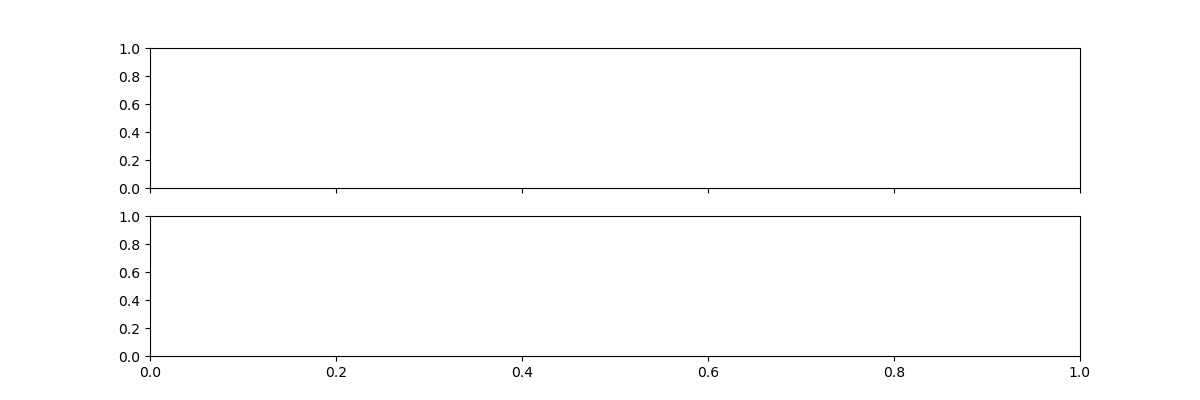

In [67]:
import scipy.stats as stats
_, ax = plt.subplots(2, 1, figsize=(12, 4), sharex=True)
plot_signal_w_epochs(signal, gamma_channel, gamma_epochs, ax=ax[0])
ax[1].plot(np.arange(0, len(gamma_amp))/sess.eegfile.sampling_rate , stats.zscore(gamma_amp))

## Sync via CS+ or CS- times in tone_recall or control_tone_recall or tone_habituation session

,channel_states,timestamps,datetimes,event_name
915,2,4516787,2022-06-24 13:34:43.559566667,
1063,-2,4814268,2022-06-24 13:34:53.475600000,
1878,2,6458292,2022-06-24 13:35:48.276400000,
2026,-2,6756457,2022-06-24 13:35:58.215233333,
2780,2,8278461,2022-06-24 13:36:48.948700000,


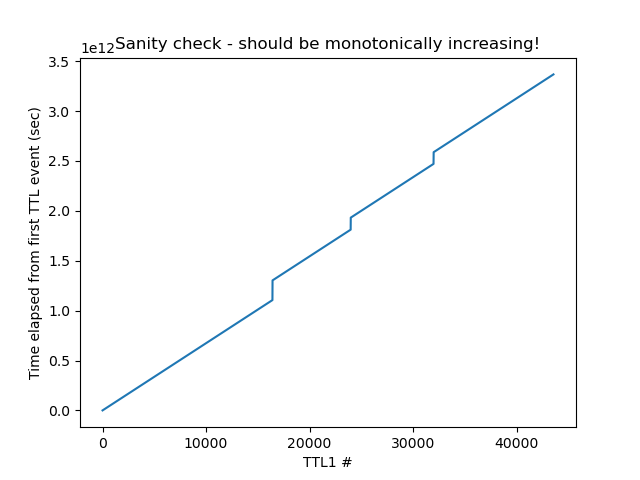

In [23]:
import neuropy.io.openephysio as oeio

# Import TTLs for CS from OpenEphys
ttl_df = oeio.load_all_ttl_events(sess.basepath, sanity_check_channel=1, zero_timestamps=True)
ttl_df[ttl_df['channel_states'].abs() == 2].head(5)

In [80]:
cs_starts, cs_stops, cs_df = traceio.load_trace_events(sess.basepath, session_type="tone_recall", 
                                                          event_type="CS+", return_df=True)
print(f'{cs_starts.shape[0]} CS+ events detected')
print(cs_starts.head(6))
    
# For control tone recall CS-
csn_starts, csn_stops, csn_df = traceio.load_trace_events(sess.basepath, session_type="control_tone_recall", 
                                                          event_type="CS-", return_df=True)
print(f'{csn_starts.shape[0]} CS- events detected')
print(csn_starts.head(6))

15 CS+ events detected
      Time (s)      Event                     Timestamp
5    61.749347  CS1_start 2022-06-24 13:34:44.431148210
7   126.466255  CS2_start 2022-06-24 13:35:49.148056188
9   187.138789  CS3_start 2022-06-24 13:36:49.820589939
11  254.915512  CS4_start 2022-06-24 13:37:57.597313085
13  332.825486  CS5_start 2022-06-24 13:39:15.507287183
15  400.601713  CS6_start 2022-06-24 13:40:23.283513704
12 CS- events detected
      Time (s)      Event                     Timestamp
5    61.626835  CS1_start 2022-06-24 13:56:26.358083108
7   142.580753  CS2_start 2022-06-24 13:57:47.312000850
9   211.372785  CS3_start 2022-06-24 13:58:56.104033091
11  280.163824  CS4_start 2022-06-24 14:00:04.895071605
13  345.895048  CS5_start 2022-06-24 14:01:10.626296141
15  418.745341  CS6_start 2022-06-24 14:02:23.476588586


In [81]:
import tracefc.io.traceio as traceio

if "training" in str(sess.basepath):
    # For tone habituation
    csn_starts, csn_stops, csn_df = traceio.load_trace_events(sess.basepath, session_type="tone_habituation", 
                                                          event_type="CS-", return_df=True)
    print(f'{csn_starts.shape[0]} CS- events detected')
    print(csn_starts.head(6))
    
    # For CS+ during training
    cs_starts, cs_stops, cs_df = traceio.load_trace_events(sess.basepath, session_type="training", 
                                                          event_type="CS+", return_df=True)
    print(f'{cs_starts.shape[0]} CS+ events detected')
    print(cs_starts.head(6))
elif "recall" in str(sess.basepath):
    # For tone recall CS+
    cs_starts, cs_stops, cs_df = traceio.load_trace_events(sess.basepath, session_type="tone_recall", 
                                                          event_type="CS+", return_df=True)
    print(f'{cs_starts.shape[0]} CS+ events detected')
    print(cs_starts.head(6))
    
    # For control tone recall CS-
    csn_starts, csn_stops, csn_df = traceio.load_trace_events(sess.basepath, session_type="control_tone_recall", 
                                                          event_type="CS-", return_df=True)
    print(f'{csn_starts.shape[0]} CS- events detected')
    print(csn_starts.head(6))

15 CS+ events detected
      Time (s)      Event                     Timestamp
5    61.749347  CS1_start 2022-06-24 13:34:44.431148210
7   126.466255  CS2_start 2022-06-24 13:35:49.148056188
9   187.138789  CS3_start 2022-06-24 13:36:49.820589939
11  254.915512  CS4_start 2022-06-24 13:37:57.597313085
13  332.825486  CS5_start 2022-06-24 13:39:15.507287183
15  400.601713  CS6_start 2022-06-24 13:40:23.283513704
12 CS- events detected
      Time (s)      Event                     Timestamp
5    61.626835  CS1_start 2022-06-24 13:56:26.358083108
7   142.580753  CS2_start 2022-06-24 13:57:47.312000850
9   211.372785  CS3_start 2022-06-24 13:58:56.104033091
11  280.163824  CS4_start 2022-06-24 14:00:04.895071605
13  345.895048  CS5_start 2022-06-24 14:01:10.626296141
15  418.745341  CS6_start 2022-06-24 14:02:23.476588586


In [82]:
sync_df = oeio.create_sync_df(sess.basepath)
sync_df

start time = 2022-06-24 13:32:13.885532-04:00
start time = 2022-06-24 13:55:14.150541-04:00
start time = 2022-06-24 14:05:46.326088-04:00
start time = 2022-06-24 14:15:38.685070-04:00


,Recording,Datetime,Condition,nframe_dat,dat_time,nframe_eeg,eeg_time
0,0,2022-06-24 13:32:13.885532-04:00,start,0,0.000000,0,0.0000
1,0,2022-06-24 13:52:19.619898667-04:00,stop,36172031,1205.734367,1507167,1205.7336
2,1,2022-06-24 13:55:14.150541-04:00,start,36172032,1205.734400,1507168,1205.7344
3,1,2022-06-24 14:03:58.982241-04:00,stop,51916983,1730.566100,2163207,1730.5656
4,2,2022-06-24 14:05:46.326088-04:00,start,51916984,1730.566133,2163208,1730.5664
5,2,2022-06-24 14:14:59.874854667-04:00,stop,68523447,2284.114900,2855143,2284.1144
6,3,2022-06-24 14:15:38.685070-04:00,start,68523448,2284.114933,2855144,2284.1152
7,3,2022-06-24 14:29:57.326103333-04:00,stop,94282679,3142.755967,3928444,3142.7552


In [94]:
cs_starts

,Time (s),Event,Timestamp
5,61.749347,CS1_start,2022-06-24 13:34:44.431148210
7,126.466255,CS2_start,2022-06-24 13:35:49.148056188
9,187.138789,CS3_start,2022-06-24 13:36:49.820589939
11,254.915512,CS4_start,2022-06-24 13:37:57.597313085
13,332.825486,CS5_start,2022-06-24 13:39:15.507287183
15,400.601713,CS6_start,2022-06-24 13:40:23.283513704
17,465.333996,CS7_start,2022-06-24 13:41:28.015796819
19,543.243970,CS8_start,2022-06-24 13:42:45.925771394
21,608.991564,CS9_start,2022-06-24 13:43:51.673364559
23,669.665089,CS10_start,2022-06-24 13:44:52.346890130


In [95]:
cs_stops

,Time (s),Event,Timestamp
6,71.665848,CS1_end,2022-06-24 13:34:54.347648778
8,136.405571,CS2_end,2022-06-24 13:35:59.087371745
10,197.075129,CS3_end,2022-06-24 13:36:59.756929794
12,264.834988,CS4_end,2022-06-24 13:38:07.516788640
14,342.764803,CS5_end,2022-06-24 13:39:25.446603694
16,410.534581,CS6_end,2022-06-24 13:40:33.216381945
18,475.254464,CS7_end,2022-06-24 13:41:37.936265388
20,553.184278,CS8_end,2022-06-24 13:42:55.866079011
22,618.923934,CS9_end,2022-06-24 13:44:01.605735460
24,679.584069,CS10_end,2022-06-24 13:45:02.265870490


In [93]:
cs_oe_start_df

,channel_states,timestamps,datetimes,event_name


In [83]:
# Grab CS times corresponding to OE timestamps
ttl_lag_use = pd.Timedelta(0.8, unit="seconds")
cs_oe_start_df = traceio.trace_ttl_to_openephys(cs_starts, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use)
cs_oe_stop_df = traceio.trace_ttl_to_openephys(cs_stops, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use)
# Convert to times in combined eeg file
cs_starts_combined = oeio.recording_events_to_combined_time(cs_oe_start_df, sync_df)
cs_stops_combined = oeio.recording_events_to_combined_time(cs_oe_stop_df, sync_df)

csn_oe_start_df = traceio.trace_ttl_to_openephys(csn_starts, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use*2)
csn_oe_stop_df = traceio.trace_ttl_to_openephys(csn_stops, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use*2)

# Convert to times in combined eeg file
csn_starts_combined = oeio.recording_events_to_combined_time(csn_oe_start_df, sync_df)
csn_stops_combined = oeio.recording_events_to_combined_time(csn_oe_stop_df, sync_df)

No matching events found. Try increasing assumed lag in "ttl_lag" param
No matching events found. Try increasing assumed lag in "ttl_lag" param
start time lag: mean = -0.2114656970909091, std = 0.08860790757310441
start time lag: mean = -0.211837868, std = 0.08857447247053857


/data/GitHub/TraceFC/tracefc/io/traceio.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace_cs_sync_df.loc[:, "datetimes"] = trace_cs_sync_df["datetimes"].dt.tz_localize(


In [84]:
# Export to neuroscope
cs_epochs = Epoch({"start": cs_starts_combined, "stop": cs_stops_combined, "label": ""})
sess.recinfo.write_epochs(cs_epochs, ext="csp")

# Save to neuropy
cs_file = sess.filePrefix.with_suffix(".cs_epochs.npy")
cs_epochs.save(cs_file)



# Export to neuroscope
csn_epochs = Epoch({"start": csn_starts_combined, "stop": csn_stops_combined, "label": ""})
sess.recinfo.write_epochs(csn_epochs, ext="csn")

# Save to neuropy
csn_file = sess.filePrefix.with_suffix(".csn_epochs.npy")
csn_epochs.save(csn_file)



/data2/Trace_FC/Recording_Rats/Jyn/2022_06_24_recall7/Jyn_recall7_denoised.cs_epochs.npy saved
/data2/Trace_FC/Recording_Rats/Jyn/2022_06_24_recall7/Jyn_recall7_denoised.csn_epochs.npy saved


In [85]:
cs_starts_combined

array([], dtype=float64)

In [86]:
csn_starts_combined

array([1277.794792, 1358.748792, 1427.540525, 1496.331325, 1562.062359,
       1634.912459, 1709.792125, 1750.698678, 1818.473712, 1879.131212,
       1958.070545])

In [87]:
csn_epochs.to_dataframe()

,start,stop,label,duration
0,1277.794792,1287.712025,,9.917233
1,1358.748792,1368.681559,,9.932767
2,1427.540525,1437.481159,,9.940634
3,1496.331325,1506.250792,,9.919467
4,1562.062359,1572.000359,,9.938000
5,1634.912459,1644.849959,,9.937500
6,1709.792125,1719.709525,,9.917400
7,1750.698678,1760.635278,,9.936600
8,1818.473712,1828.394912,,9.921200
9,1879.131212,1889.064512,,9.933300


In [88]:
# For CS+ at end of control_tone_recall
cs2_starts, cs2_ends, cs2_df = traceio.load_trace_events(sess.basepath, session_type="control_tone_recall", 
                                                      event_type="CS+", return_df=True)
print(f'{cs2_starts.shape[0]} CS+ events detected during {sess_name} control tone recall')
print(cs2_starts.head(6))

cs2_oe_start_df = traceio.trace_ttl_to_openephys(cs2_starts, 
                                      ttl_df[ttl_df['channel_states'].abs() == 2], 
                                      ttl_lag=ttl_lag_use)
# Convert to times in combined eeg file
cs2_starts_combined = oeio.recording_events_to_combined_time(cs2_oe_start_df, sync_df)

cs2_oe_stop_df = traceio.trace_ttl_to_openephys(cs2_ends, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use)
# Convert to times in combined eeg file
cs2_stops_combined = oeio.recording_events_to_combined_time(cs2_oe_stop_df, sync_df)

# Export to neuroscope
cs2_epochs = Epoch({"start": cs2_starts_combined, "stop": cs2_stops_combined, "label": ""})
sess.recinfo.write_epochs(cs2_epochs, ext="cs2")

# Save to neuropy
cs2_file = sess.filePrefix.with_suffix(".cs2_epochs.npy")
cs2_epochs.save(cs2_file)


3 CS+ events detected during recall7 control tone recall
       Time (s)           Event                     Timestamp
29   910.095132  CS_end_1_start 2022-06-24 14:10:34.826380351
31   971.767606  CS_end_2_start 2022-06-24 14:11:36.498853782
33  1050.706785  CS_end_3_start 2022-06-24 14:12:55.438032725
start time lag: mean = -0.3239445083333333, std = 0.0002769718354081136
start time lag: mean = -0.324467817, std = 0.00046098869140575937
/data2/Trace_FC/Recording_Rats/Jyn/2022_06_24_recall7/Jyn_recall7_denoised.cs2_epochs.npy saved


/data/GitHub/TraceFC/tracefc/io/traceio.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace_cs_sync_df.loc[:, "datetimes"] = trace_cs_sync_df["datetimes"].dt.tz_localize(


In [89]:
csn_starts_combined

array([1277.794792, 1358.748792, 1427.540525, 1496.331325, 1562.062359,
       1634.912459, 1709.792125, 1750.698678, 1818.473712, 1879.131212,
       1958.070545])

In [90]:
cs_oe_start_df

,channel_states,timestamps,datetimes,event_name


### How to write CS+ to neuroscope event file

In [50]:
cs_tone_recall_epochs = Epoch({"start": cs_starts_combined, "stop": cs_stops_combined, "label": ["CS+"]*len(cs_starts_combined)})
cs_tone_recall_epochs
sess.recinfo.write_epochs(cs_tone_recall_epochs, "cs+")

In [51]:
cs_tone_recall_epochs.to_dataframe()

,start,stop,label,duration


In [52]:
sess_use

<function __main__.sess_use(basepath='/data/GitHub/TraceFC/Notebooks/Animal_files/Recall7 Notebooks')>

In [53]:
from tracefc.io.traceio import grab_usv_folder
csp_wav = grab_usv_folder(sess.basepath, 'csp')
print(csp_wav)
# Get CS+ times and plot to check
cs_wav_epochs = detect_tone(csp_wav, freq_lims=(6900, 7150), thresh=0, tone_length=10, tone_label="CS+", plot_check=True)
# Check that lags are consistent
if (animal == 'Django') & (sess_name == 'training'):
    cs_starts_combined = cs_starts_combined[:5]
    cs_stops_combined = cs_stops_combined[:5]
cs_start_lags = cs_starts_combined - cs_wav_epochs.starts
print(f"Mean start lag time of {np.mean(cs_start_lags):0.3F} sec with std = {np.std(cs_start_lags):0.3F} sec. Add lags from wavfile times to get ephys times")
cs_stop_lags = cs_stops_combined - cs_wav_epochs.stops
print(f"Mean stop lag time of {np.mean(cs_stop_lags):0.3F} sec with std = {np.std(cs_stop_lags):0.3F} sec.")

None


TypeError: Invalid file: None

Ditto for CS-

In [54]:
# Detect CS- in audio recording.
csn_wav = grab_usv_folder(sess.basepath, "csn")
print(csn_wav)

# Get CS+ times and plot to check
csn_wav_epochs, csn_wav_stop = detect_tone(csn_wav, freq_lims=(900, 1100), thresh=-0.1, tone_length=10, tone_label="CS-", 
                                           plot_check=True, return_stop=True)

# Check that lags are consistent
csn_start_lags = csn_starts_combined - csn_wav_epochs.starts
print(f"Mean start lag time of {np.mean(csn_start_lags):0.3F} sec with std = {np.std(csn_start_lags):0.3F} sec. Add lags from wavfile times to get ephys times")
csn_stop_lags = csn_stops_combined - csn_wav_epochs.stops
print(f"Mean stop lag time of {np.mean(csn_stop_lags):0.3F} sec with std = {np.std(csn_stop_lags):0.3F} sec.")

None


TypeError: Invalid file: None

Now try to sync to start tone 

In [55]:
ctx_recall_wav = sorted((sess.basepath / "3_post").glob("**/*.wav"))[0]
print(ctx_recall_wav)

# Get CS+ times and plot to check
start_wav_epochs = detect_tone(ctx_recall_wav, freq_lims=(450, 550), thresh=10, tone_length=0.5, tone_label="start_tone", plot_check=True)

IndexError: list index out of range

In [56]:
cs_wav_epochs.to_dataframe()

NameError: name 'cs_wav_epochs' is not defined

In [57]:
csn_wav_epochs.to_dataframe()

NameError: name 'csn_wav_epochs' is not defined

## Sync recorded USV times to ephys file

In [58]:
# Read in USV times from tone recall session
from neuropy.io.usvio import DeepSqueakIO
csp_wav = Path(csp_wav)
usv_detect_file = sorted(csp_wav.parent.glob(f"**/{csp_wav.name[:-4]}*_cell.mat"))[0]

ds_calls = DeepSqueakIO(filename=usv_detect_file)
ds_calls.load_calls()
ds_calls.usv_df

TypeError: expected str, bytes or os.PathLike object, not NoneType

### Plot lags vs time to check for drift between ephys and audio recordings and correct if necessary

NameError: name 'cs_wav_epochs' is not defined

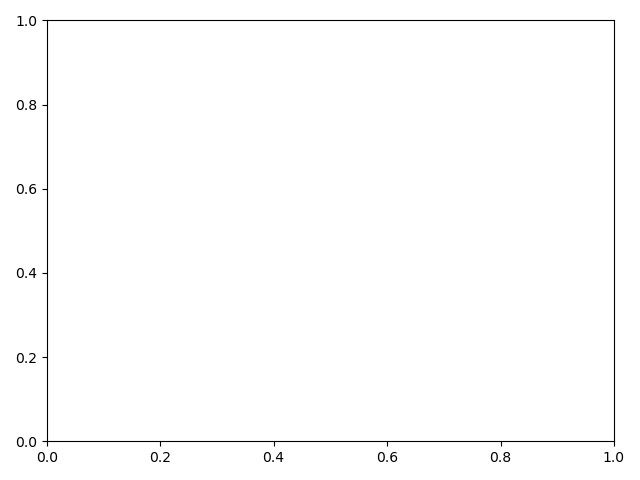

In [59]:
from scipy.linalg import lstsq

_, ax = plt.subplots(layout='tight')
cs_times_wav = np.stack((cs_wav_epochs.starts, cs_wav_epochs.stops), axis=1)
cs_lags_comb = np.stack((cs_start_lags, cs_stop_lags), axis=1)
hl = ax.plot(cs_times_wav, cs_lags_comb)
ax.set_xlabel('WAV time (sec) #')
ax.set_ylabel('Lag between TTL and WAV detected CS (sec)')
ax.legend(hl, ('CS Start', 'CS Stop'))

# Fit function to approximate drift
y = cs_lags_comb.T.reshape(-1)
M = np.stack((np.ones_like(cs_lags_comb.reshape(-1)), cs_times_wav.T.reshape(-1)), axis=1)
p, res, rnk, s = lstsq(M, y)
hfit = ax.plot(cs_times_wav.T.reshape(-1), p[0] + p[1]*cs_times_wav.T.reshape(-1), 'r-.')
hl.extend(hfit)
ax.legend(hl, ('CS start', 'CS stop', 'fit'))

In [60]:
# Sanity check code to output corrected CS times from WAV file to Neuroscope
cs_wav_starts_aligned = cs_wav_epochs.starts + p[0] + p[1]*cs_wav_epochs.starts
cs_wav_stops_aligned = cs_wav_epochs.stops + p[0] + p[1]*cs_wav_epochs.stops
cs_wav_epochs_aligned = Epoch({"start": cs_wav_starts_aligned, "stop": cs_wav_stops_aligned, 
                               "label": ["CS+ from WAV file"]*len(cs_wav_stops_aligned)})


cs_epochs_files = sess.filePrefix.with_suffix(".cs_wav_epochs.npy")
cs_wav_epochs_aligned.save(cs_epochs_files)
sess.recinfo.write_epochs(cs_wav_epochs_aligned, ext="wv+")

NameError: name 'cs_wav_epochs' is not defined

In [61]:
cs_wav_epochs_aligned.to_dataframe()

NameError: name 'cs_wav_epochs_aligned' is not defined

### Now do the same but for the CS-

NameError: name 'csn_wav_epochs' is not defined

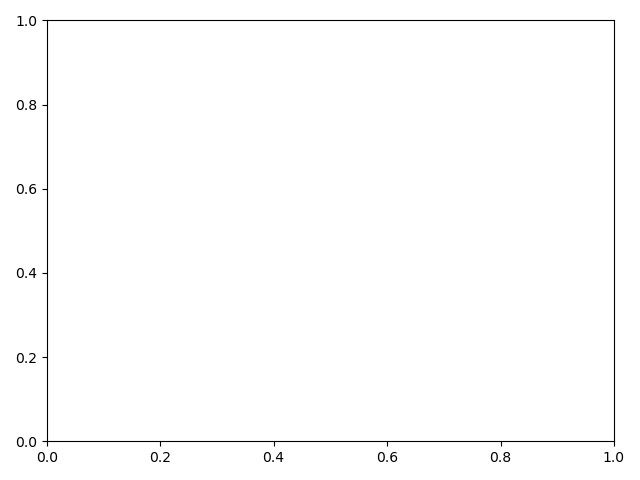

In [41]:
_, ax = plt.subplots(layout='tight')
csn_times_wav = np.stack((csn_wav_epochs.starts, csn_wav_epochs.stops), axis=1)
csn_lags_comb = np.stack((csn_start_lags, csn_stop_lags), axis=1)
hl = ax.plot(csn_times_wav, csn_lags_comb)
ax.set_xlabel('WAV time (sec) #')
ax.set_ylabel('Lag between TTL and WAV detected CS (sec)')
ax.legend(hl, ('CS Start', 'CS Stop'))

# Fit function to approximate drift
y = csn_lags_comb.T.reshape(-1)
M = np.stack((np.ones_like(csn_lags_comb.reshape(-1)), csn_times_wav.T.reshape(-1)), axis=1)
p, res, rnk, s = lstsq(M, y)
hfit = ax.plot(csn_times_wav.T.reshape(-1), p[0] + p[1]*csn_times_wav.T.reshape(-1), 'r-.')
hl.extend(hfit)
ax.legend(hl, ('CS- start', 'CS- stop', 'fit'))

In [42]:
# Sanity check code to output corrected CS- times from WAV file to Neuroscope
csn_wav_starts_aligned = csn_wav_epochs.starts + p[0] + p[1]*csn_wav_epochs.starts
csn_wav_stops_aligned = csn_wav_epochs.stops + p[0] + p[1]*csn_wav_epochs.stops
csn_wav_epochs_aligned = Epoch({"start": csn_wav_starts_aligned, "stop": csn_wav_stops_aligned, 
                               "label": ["CS- from WAV file"]*len(csn_wav_stops_aligned)})


csn_epochs_files = sess.filePrefix.with_suffix(".csn_wav_epochs.npy")
csn_wav_epochs_aligned.save(csn_epochs_files)
sess.recinfo.write_epochs(csn_wav_epochs_aligned, ext="wv-")

NameError: name 'csn_wav_epochs' is not defined

In [43]:
csn_wav_epochs_aligned.to_dataframe()

NameError: name 'csn_wav_epochs_aligned' is not defined

In [44]:
# Bowen to detect CS2 again here before running below.

# Detect CS- in audio recording.
cs2_wav = grab_usv_folder(sess.basepath, "cs2")
print(cs2_wav)

# Get CS+ times and plot to check
cs2_wav_epochs = detect_tone(cs2_wav, freq_lims=(6900, 7150), thresh=0, tone_length=10, tone_label="CS2", plot_check=True)
# Check that lags are consistent
cs_start_lags = cs_starts_combined - cs_wav_epochs.starts
print(f"Mean start lag time of {np.mean(cs_start_lags):0.3F} sec with std = {np.std(cs_start_lags):0.3F} sec. Add lags from wavfile times to get ephys times")
cs_stop_lags = cs_stops_combined - cs_wav_epochs.stops
print(f"Mean stop lag time of {np.mean(cs_stop_lags):0.3F} sec with std = {np.std(cs_stop_lags):0.3F} sec.")

NameError: name 'grab_usv_folder' is not defined

In [37]:
# Sanity check code to output corrected CS2 times from WAV file to Neuroscope
cs2_wav_starts_aligned = cs2_wav_epochs.starts + p[0] + p[1]*cs2_wav_epochs.starts
cs2_wav_stops_aligned = cs2_wav_epochs.stops + p[0] + p[1]*cs2_wav_epochs.stops
cs2_wav_epochs_aligned = Epoch({"start": cs2_wav_starts_aligned, "stop": cs2_wav_stops_aligned, 
                               "label": ["CS2 from WAV file"]*len(cs2_wav_stops_aligned)})


cs2_epochs_files = sess.filePrefix.with_suffix(".cs2_wav_epochs.npy")
cs2_wav_epochs_aligned.save(cs2_epochs_files)
sess.recinfo.write_epochs(cs2_wav_epochs_aligned, ext="wv2")

NameError: name 'cs2_wav_epochs' is not defined

Now correct that drift and find corrected lags!

In [44]:
# This should eventually be folded into the DeepSqueakIO class!
# Bowen question: 
calls_accept_df = ds_calls.usv_df[ds_calls.usv_df['Accept'] == 1]
call_starts_wav = calls_accept_df['Begin_Time'].values
call_stops_wav = call_starts_wav + calls_accept_df['Duration'].values
calls_accept_df.insert(0, "start", call_starts_wav + p[0] + p[1]*call_starts_wav)
calls_accept_df.insert(1, "stop", call_stops_wav + p[0] + p[1]*call_stops_wav)
calls_accept_df.insert(calls_accept_df.shape[1], "label", "")
good_calls = Epoch(calls_accept_df)

# output to neuroscope and neuropy
sess.recinfo.write_epochs(good_calls, ext="usv")
usv_epochs_file = sess.filePrefix.with_suffix(".usv_epochs.npy")
good_calls.save(usv_epochs_file)

NameError: name 'ds_calls' is not defined

In [ ]:
good_calls

## Save notebook to working directory

In [ ]:
from neuropy.core.session import ProcessData

def sess_use(basepath=os.getcwd()):

    return ProcessData(basepath)